In [2]:
from brainways_lightning_module import BrainwaysLightningModule
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from bg_atlasapi import BrainGlobeAtlas
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from datamodule import BrainwaysDataModule
import torch

In [3]:
checkpoint_path = "/home/ben/python/brm2/lightning_logs/version_92/checkpoints/epoch=0-step=18000.ckpt"
lit_module = BrainwaysLightningModule.load_from_checkpoint(checkpoint_path)
lit_module.freeze()
model = lit_module.model.to("cpu")

In [4]:
datamodule = BrainwaysDataModule(batch_size=1)

Bg_atlasapi: whs_sd_rat_39um version 1.0 is not the latest available (1.1). To update the atlas run in the 
terminal:
    brainglobe update -a whs_sd_rat_39um

Bg_atlasapi: whs_sd_rat_39um version 1.0 is not the latest available (1.1). To update the atlas run in the 
terminal:
    brainglobe update -a whs_sd_rat_39um

Bg_atlasapi: whs_sd_rat_39um version 1.0 is not the latest available (1.1). To update the atlas run in the 
terminal:
    brainglobe update -a whs_sd_rat_39um

In [5]:
atlas = BrainGlobeAtlas("whs_sd_rat_39um")
atlas_reference = (
    atlas.reference / atlas.reference.max()
).astype(np.float32)

Bg_atlasapi: whs_sd_rat_39um version 1.0 is not the latest available (1.1). To update the atlas run in the 
terminal:
    brainglobe update -a whs_sd_rat_39um

In [6]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255
transform = A.Compose(
    [
        A.Resize(224, 224),
        A.ToRGB(),
        A.Normalize(mean=ADE_MEAN, std=ADE_STD),
        ToTensorV2(),
    ]
)

In [7]:
atlas_reference.shape

(1024, 512, 512)

In [8]:
transformed_atlas = torch.stack(
    [transform(image=atlas_slice)["image"] for atlas_slice in atlas_reference]
)

In [9]:
transformed_atlas.shape

torch.Size([1024, 3, 224, 224])

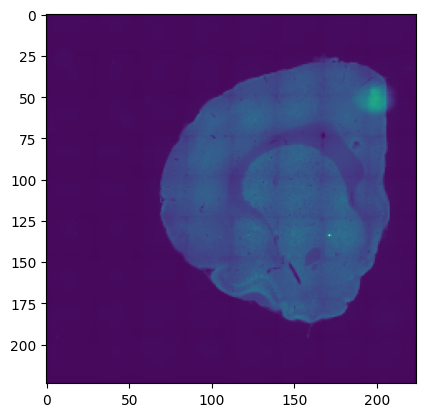

In [10]:
dataset = iter(datamodule.test_dataset)
sample = next(dataset)
image = sample["image_a"]
label = sample["ap_a"]
# image_path = "/home/ben/brainways/brainways-reg-model/data/real/test/images/2015_pilot_2/28-1/p2_28-1_s2.czi [Scene #0 Channel #0].tif"
# image = np.array(Image.open(image_path))
# label = 337.017578
_ = plt.imshow(image[0])

100%|██████████| 85/85 [00:03<00:00, 24.80it/s]


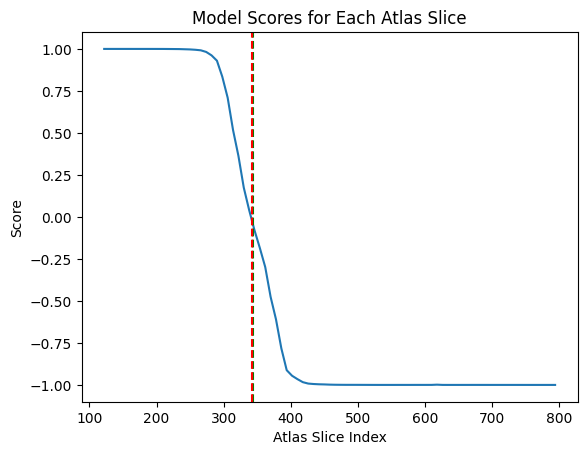

In [11]:
from constants import MAX_AP, MIN_AP
from tqdm import tqdm

image_input = image.unsqueeze(0)
pred = model.predict(image_input, transformed_atlas)

scores = []
xs = list(range(MIN_AP, MAX_AP, 8))

# Iterate over each slice in the atlas
for i in tqdm(xs):
    atlas_slice = transformed_atlas[i]
    # Run the model on the image and atlas slice
    output = model(image_input, atlas_slice.unsqueeze(0))
    
    # Assuming that the output is a score, append it to the scores list
    scores.append(output["preds"].item())

# Plot the scores
plt.plot(xs, scores)
plt.axvline(x=label, color='g', linestyle='--')
plt.axvline(x=pred, color='r', linestyle='--')
plt.xlabel('Atlas Slice Index')
plt.ylabel('Score')
plt.title('Model Scores for Each Atlas Slice')
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

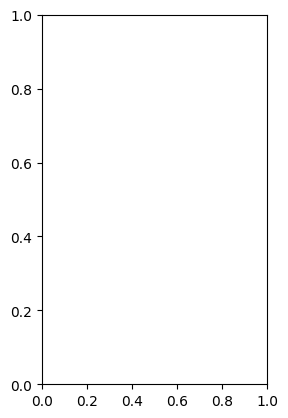

In [12]:
# show pred and atlas slices side by side
plt.subplot(1, 2, 1)
plt.imshow(atlas_reference[label])
plt.title('Atlas Slice')
plt.subplot(1, 2, 2)
plt.imshow(atlas_reference[pred])
plt.title('Predicted Atlas Slice')
plt.show()